# Crimes summed up
#### This is the Jupyter Notebook for analyzing the relationship between the sum of all kinds of crimes and community areas' different socioeconomic status. To be clear, No_Crimes is the number of crimes happended on average in one year during the 2008 - 2012 time period.

First we import data from the City of Chicago Data Portal's API.
The exported csv file from the website is over 1.5 GB and hard to work with.

In [1]:
import pandas as pd
import json
import requests
import scipy
from scipy import special
from urllib.parse import quote
%matplotlib inline 

# Get crime data 
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT community_area AS Community, count(*)/5 AS No_Crimes ")
soql += quote("WHERE 2007 < year AND year < 2013 ")
soql += quote("GROUP BY Community LIMIT 10000")

resp = requests.get(soql).json()

crime_total = pd.DataFrame(resp)

# Get rid of the redundant decimal places 
crime_total.No_Crimes = crime_total.No_Crimes.astype(float)
crime_total.round(1) 

crime_total.dropna(axis = 0, how = "any", inplace = True)   
# crime_total.head() 


In [4]:
# Get socioeconomics data 
socioeconomics = pd.read_csv("./../data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv", index_col = ['Community Area Number']) 

# Merge crime data on socioeconomics data using Communty Area Number 
crime_total.rename(columns={'Community':'Community Area Number'}, inplace = True)
crime_total.set_index('Community Area Number')

mix_total = pd.DataFrame.join(crime_total, socioeconomics)
mix_total.dropna(axis = 0, how = "any", inplace = True)  
# mix_total

Our dataset contains much data as percentage. We therefore performed logit transformation on them to acquire more sensible results. 

In [5]:
# create a logit-processed dataframe
mix_total_logit = mix_total.copy()
mix_total_logit['PERCENT OF HOUSING CROWDED'] = scipy.special.logit(mix_total_logit['PERCENT OF HOUSING CROWDED']/100)
mix_total_logit['PERCENT HOUSEHOLDS BELOW POVERTY'] = scipy.special.logit(mix_total_logit['PERCENT HOUSEHOLDS BELOW POVERTY']/100)
mix_total_logit['PERCENT AGED 16+ UNEMPLOYED'] = scipy.special.logit(mix_total_logit['PERCENT AGED 16+ UNEMPLOYED']/100)
mix_total_logit['PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA'] = scipy.special.logit(mix_total_logit['PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA']/100)
mix_total_logit['PERCENT AGED UNDER 18 OR OVER 64'] = scipy.special.logit(mix_total_logit['PERCENT AGED UNDER 18 OR OVER 64']/100)

In [6]:
# Getting into the regression

%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

import pytz

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

/home/bac2qh/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
socio_list = ['PERCENT OF HOUSING CROWDED',
 'PERCENT HOUSEHOLDS BELOW POVERTY',
 'PERCENT AGED 16+ UNEMPLOYED',
 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'PERCENT AGED UNDER 18 OR OVER 64',
 'PER CAPITA INCOME ',
 'HARDSHIP INDEX'
             ]

In [8]:
ax_name_logit = ['output/ax_Crowd_logit', 'output/ax_Poverty_logit', 
                 'output/ax_Unemp_logit', 'output/ax_Edu_logit', 
                 'output/ax_Age_logit', 'output/ax_Income_logit', 
                 'output/ax_Hardship_logit']
ax_name = ['output/ax_Crowd', 'output/ax_Poverty', 
           'output/ax_Unemp', 'output/ax_Edu', 
           'output/ax_Age', 'output/ax_Income', 
           'output/ax_Hardship']

Here we plot the non-logit format datasets as well in order to see the effect of logit-transformation.

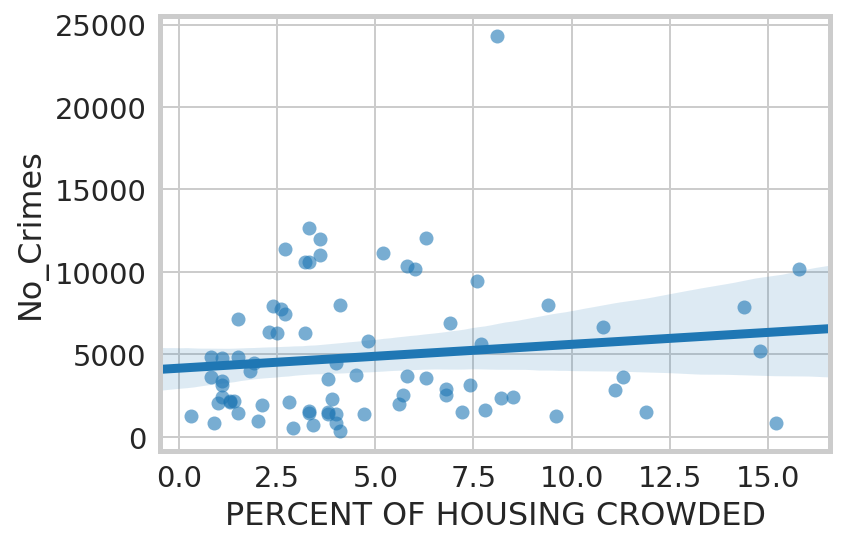

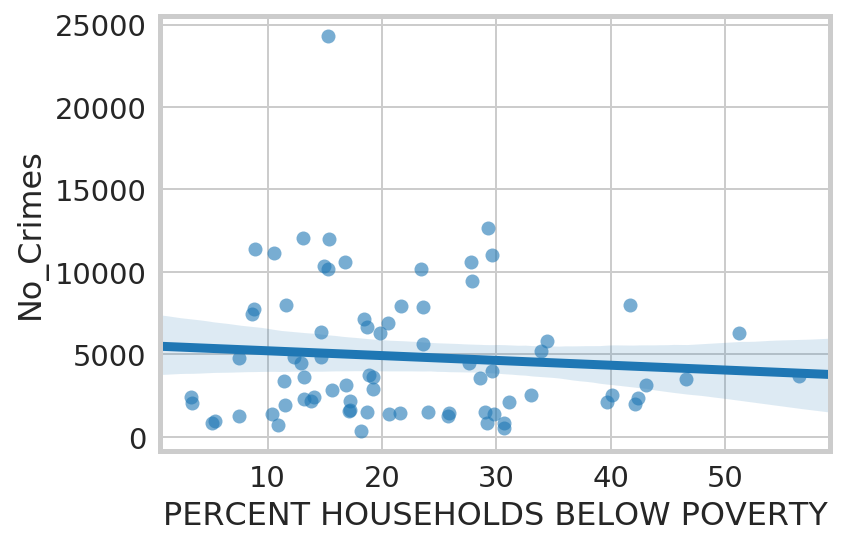

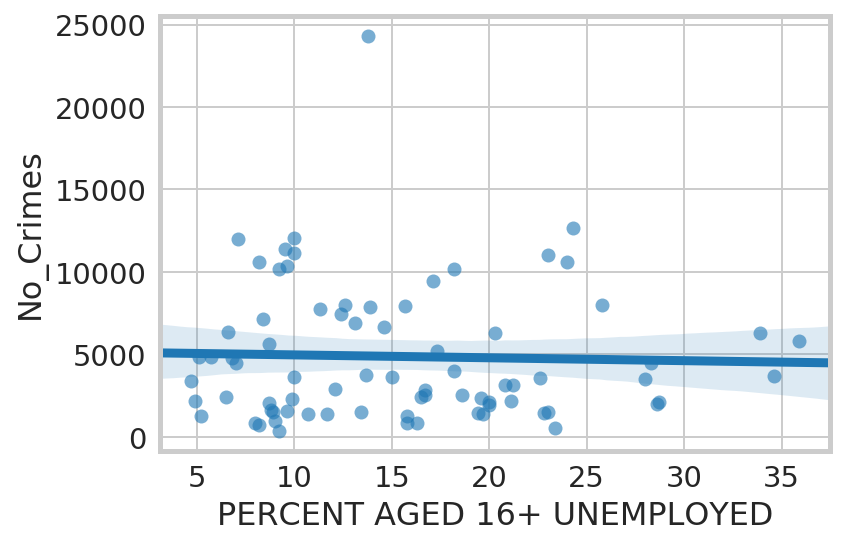

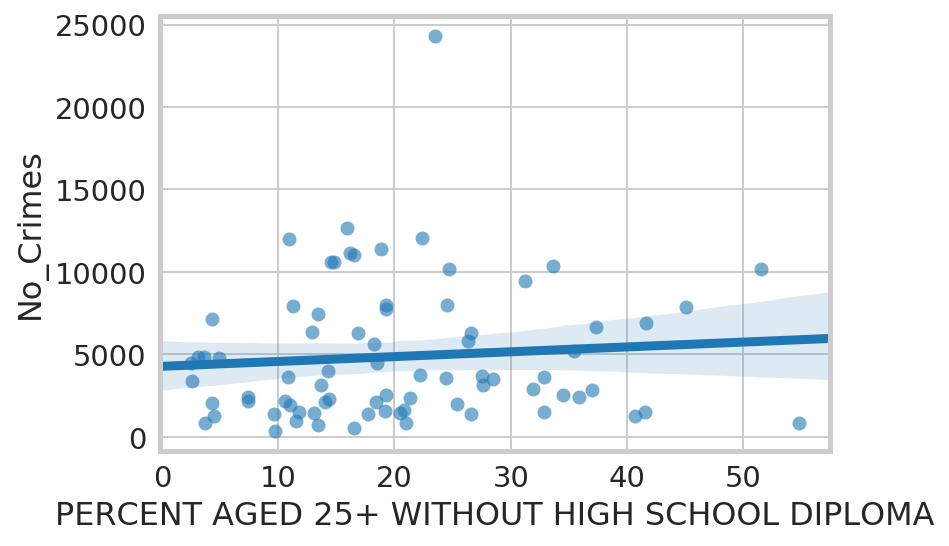

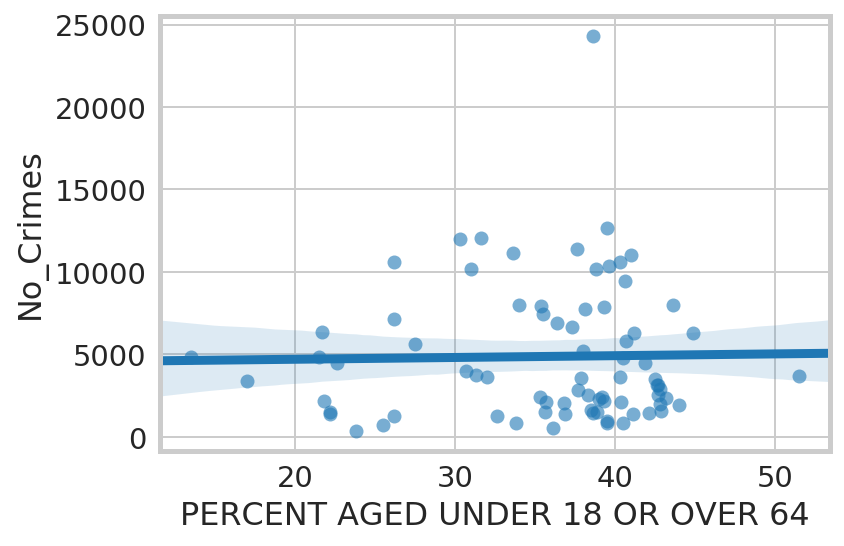

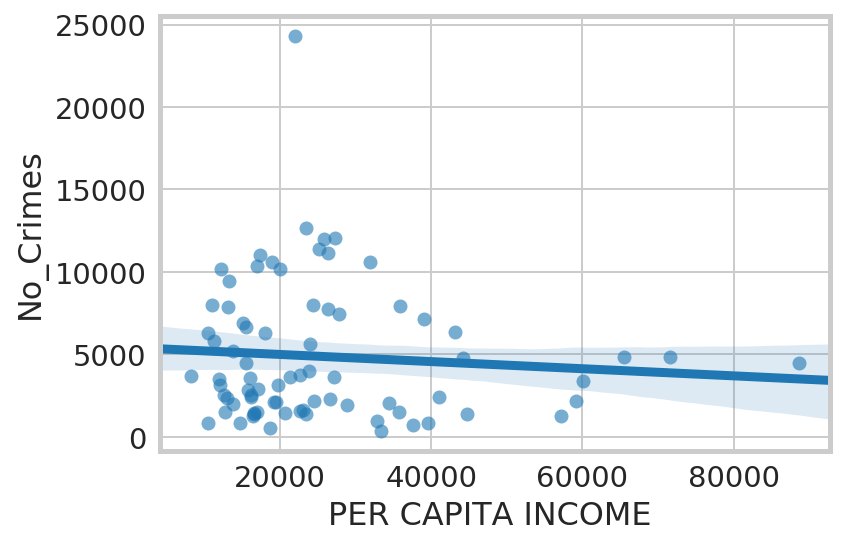

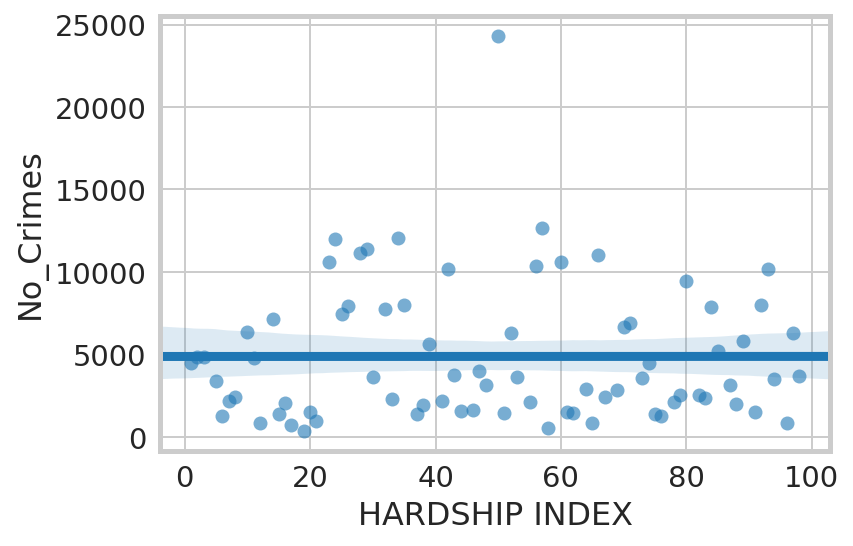

In [9]:
# orginal plots
counter = 0
for entry in socio_list:
    ax = plt.figure()
    sns.regplot(x = entry, y = 'No_Crimes', data = mix_total, scatter_kws = {"alpha" : 0.6})
#     ax.savefig('{}.png'.format(ax_name[counter]), bbox_inches='tight', pad_inches=0.2)
    counter += 1

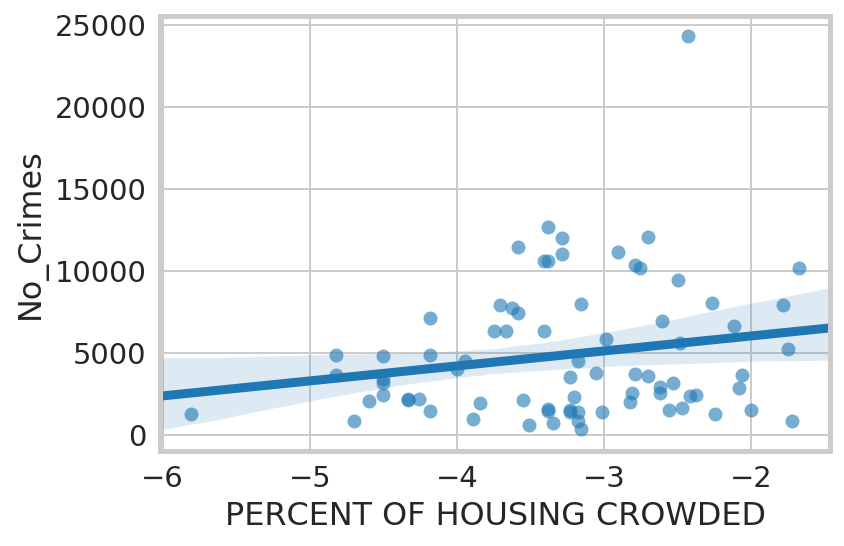

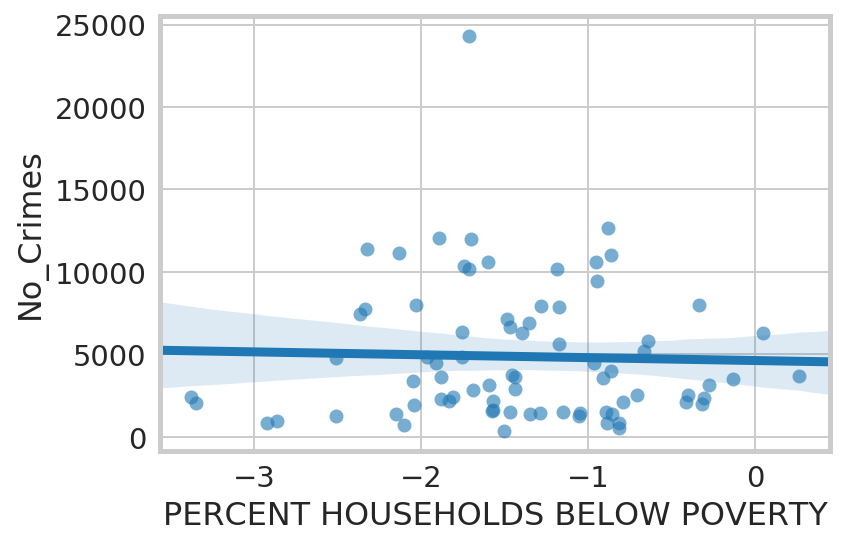

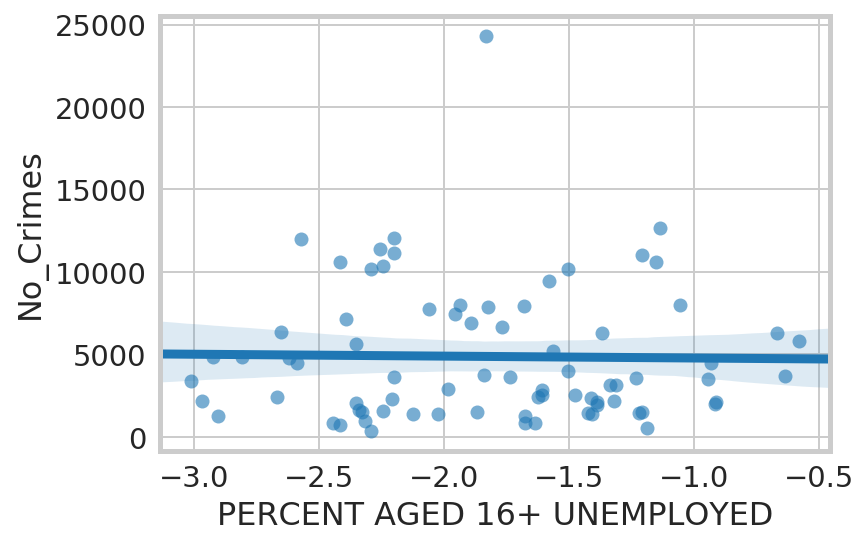

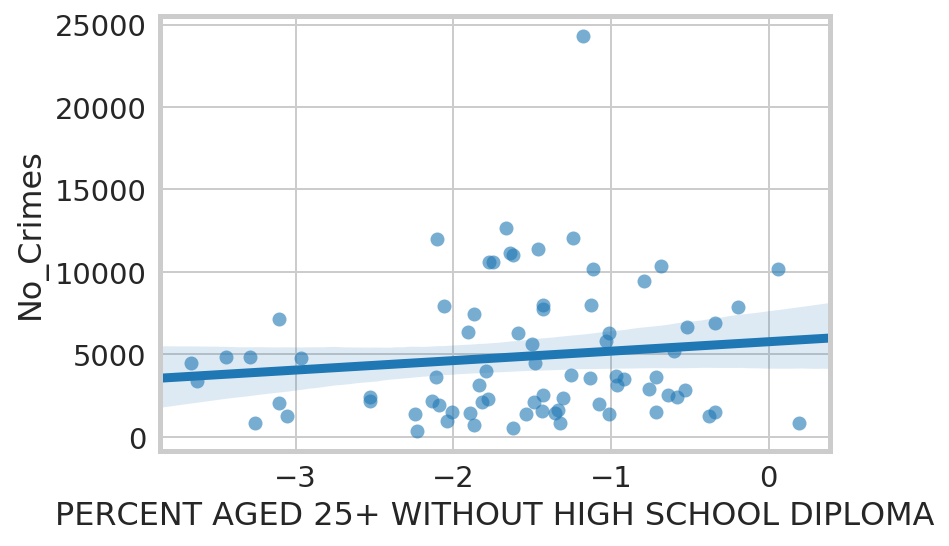

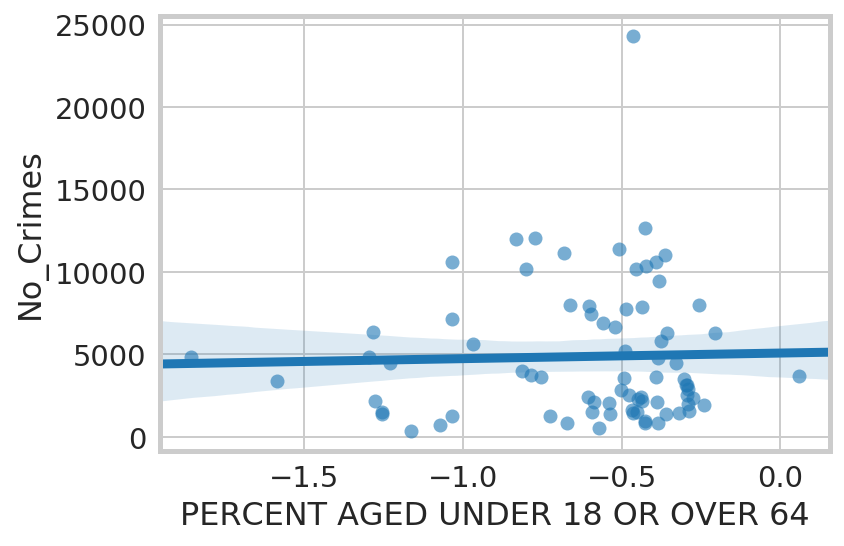

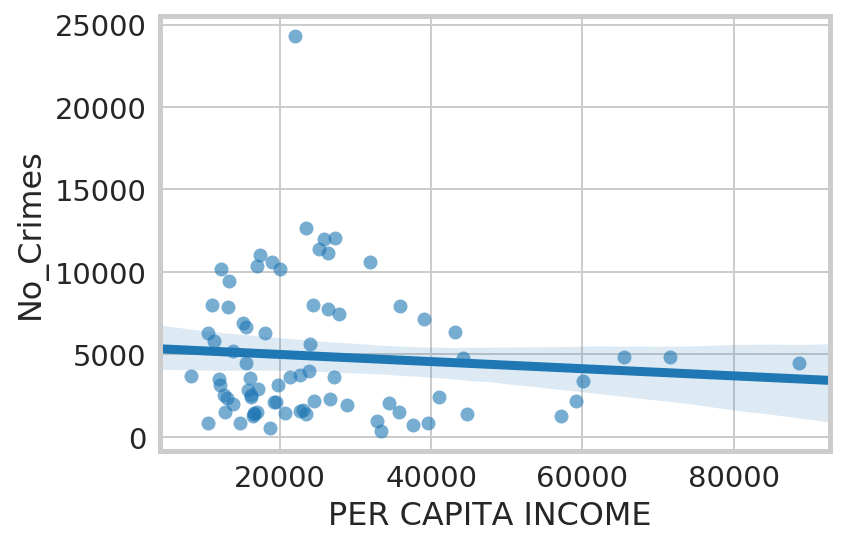

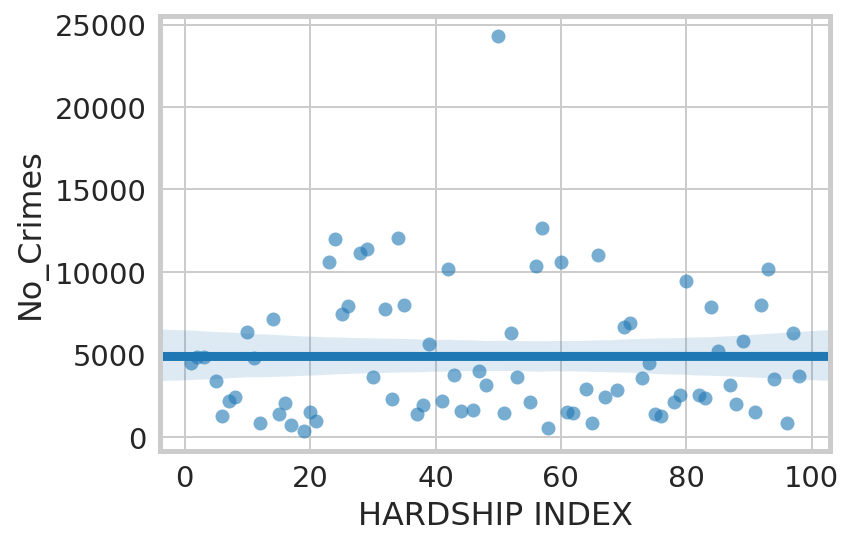

In [10]:
# create logit plots
counter = 0
for entry in socio_list:
    ax = plt.figure()
    sns.regplot(x = entry, y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6})
#     ax.savefig('{}.png'.format(ax_name_logit[counter]), bbox_inches='tight', pad_inches=0.2)
    counter += 1

The results we got here does not look good. They does not show up a clear relation between the crime and socioeconomic indicators, especially for the hadship index one, the slope is pretty close to 1. We think this may because of the great disparity with respect to the incidence of different types of crime (different causes for them). But for now, we still want to explore more about it to confirm our thought.  

#### And also, notice that there is a dot especially higher than all the others

In [11]:
mix_total[mix_total.No_Crimes >= 20000]  

# So that outlier should be Montclaire. 

,Community Area Number,No_Crimes,COMMUNITY AREA NAME,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
18,25,24329.2,Montclaire,8.1,15.3,13.8,23.5,38.6,22014.0,50.0


Now we can start to look at 
the summary for the OLS regression of Number of Crimes against Hardship Index

In [12]:
ols = smf.ols(formula = "Crime ~ Hardship",
              data = mix_total_logit.rename(columns = {"No_Crimes"                            : "Crime", 
                                                 "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                 "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                 "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                 "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                 "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                 "PER CAPITA INCOME "                         : "Income",
                                                 "HARDSHIP INDEX"                             : "Hardship"}))
model = ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Crime   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                 2.939e-06
Date:                Mon, 04 Dec 2017   Prob (F-statistic):              0.999
Time:                        13:28:56   Log-Likelihood:                -749.56
No. Observations:                  77   AIC:                             1503.
Df Residuals:                      75   BIC:                             1508.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4872.3766    945.818      5.151      0.0

Hardship Index by definition, is the scores that incorporates each of the six selected socioeconomic indicators in the dataset. This gave us a very general idea about the relationships but we would love to dig deeper into each socioeconomic indicators

In [13]:
ols = smf.ols(formula = "Crime ~ Crowd + Poverty + Unemp + Edu + Age + Income",
              data = mix_total_logit.rename(columns = {"No_Crimes"                            : "Crime", 
                                                 "PERCENT OF HOUSING CROWDED"                 : "Crowd", 
                                                 "PERCENT HOUSEHOLDS BELOW POVERTY"           : "Poverty", 
                                                 "PERCENT AGED 16+ UNEMPLOYED"                : "Unemp",
                                                 "PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA": "Edu",
                                                 "PERCENT AGED UNDER 18 OR OVER 64"           : "Age", 
                                                 "PER CAPITA INCOME "                         : "Income",
                                                 "HARDSHIP INDEX"                             : "Hardship"}))
model = ols.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Crime   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.7487
Date:                Mon, 04 Dec 2017   Prob (F-statistic):              0.612
Time:                        13:28:57   Log-Likelihood:                -747.16
No. Observations:                  77   AIC:                             1508.
Df Residuals:                      70   BIC:                             1525.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8931.1397   3238.900      2.757      0.0

Again, the P-values are not small enough to give us any statistically significant coefficients. From this result, it seems hard for us to say that crime is associated with socioeconomic status for communities. But this confirms our thought that due to great difference within different types of crime, the number of total crime might not be a good choice to explore this statistical relation. 

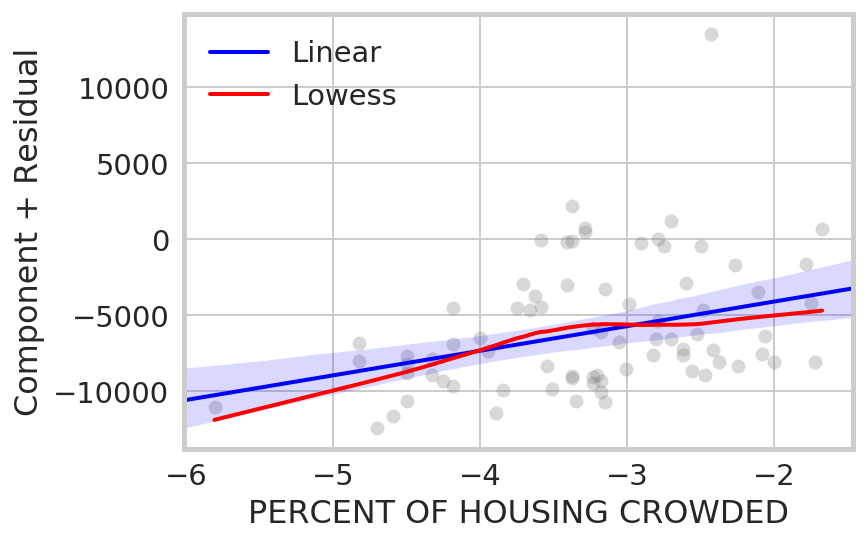

In [14]:
# logit 
chc = pd.Series(name = "Component + Residual", data = model.resid + mix_total_logit["PERCENT OF HOUSING CROWDED"] * model.
                params["Crowd"])
ax = sns.regplot(x = mix_total_logit["PERCENT OF HOUSING CROWDED"], y = chc, scatter = True, fit_reg = False,
            scatter_kws = {"alpha" : 0.3, "color" : "grey"})
sns.regplot(x = mix_total_logit["PERCENT OF HOUSING CROWDED"], y = chc, scatter = False, 
            lowess = False, robust = True, label = "Linear",
            scatter_kws = {"alpha" : 0.3, "color" : "grey"}, line_kws = {"color" : "blue", "linewidth" : 2})
sns.regplot(x = mix_total_logit["PERCENT OF HOUSING CROWDED"], y = chc, scatter = False, 
            lowess = True, label = "Lowess",
            scatter_kws = {"alpha" : 0}, line_kws = {"color" : "red", "linewidth" : 2}, ax = ax);

ax.legend()
# ax.figure.savefig('output/housing_logit.png')

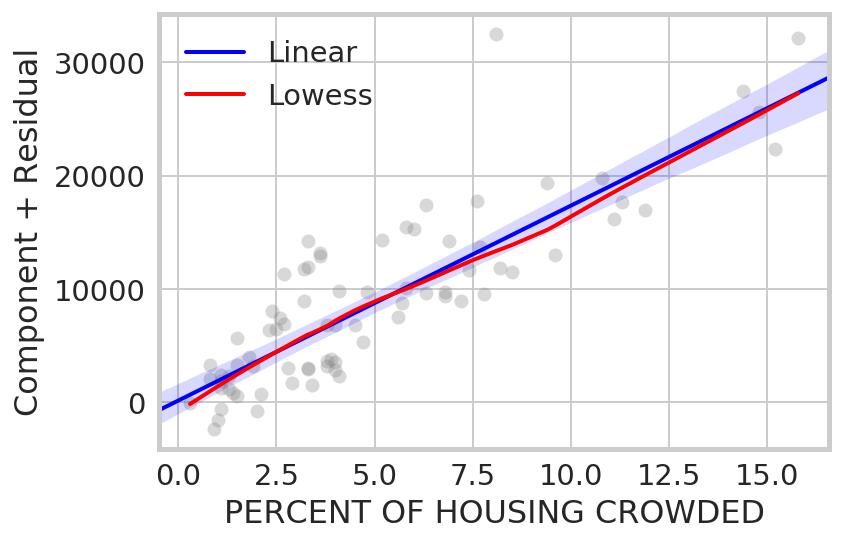

In [15]:
# regular
chc = pd.Series(name = "Component + Residual", data = model.resid + mix_total["PERCENT OF HOUSING CROWDED"] * model.
                params["Crowd"])
ax = sns.regplot(x = mix_total["PERCENT OF HOUSING CROWDED"], y = chc, scatter = True, fit_reg = False,
            scatter_kws = {"alpha" : 0.3, "color" : "grey"})
sns.regplot(x = mix_total["PERCENT OF HOUSING CROWDED"], y = chc, scatter = False, 
            lowess = False, robust = True, label = "Linear",
            scatter_kws = {"alpha" : 0.3, "color" : "grey"}, line_kws = {"color" : "blue", "linewidth" : 2})
sns.regplot(x = mix_total["PERCENT OF HOUSING CROWDED"], y = chc, scatter = False, 
            lowess = True, label = "Lowess",
            scatter_kws = {"alpha" : 0}, line_kws = {"color" : "red", "linewidth" : 2}, ax = ax);

ax.legend()
# ax.figure.savefig('output/housing.png')

### We thought better of what we initially developed.
so here I list them in blocks for any reference purposes. 

In [ ]:
# preliminary fit

# # ols_cr_hard = smf.ols(formula = "NC ~ H",
# #               data = crime_hardship.rename(columns = {"HARDSHIP INDEX":"H","No_Crimes":"NC"})) 
# # model_cr_hard = ols_cr_hard.fit()
# # model_cr_hard.summary() 

# result = smf.ols('NC ~ HI', 
#                  data = mix_total_logit.rename(columns = {'HARDSHIP INDEX':'HI', 'No_Crimes':'NC'})
#                 )
# result.fit().summary()

# # the coefficient for hardship index in not statistically significant 

In [231]:
# replaced by better nicknames like Crowds and so on

# result2 = smf.ols('NC ~ PHC + PHBP + PA16 + PA25 + PA + PCI + HI', 
#                  data = mix_total_logit.rename(columns = {'No_Crimes':'NC',
#                                                           'PERCENT OF HOUSING CROWDED':'PHC',
#                                                           'PERCENT HOUSEHOLDS BELOW POVERTY':'PHBP',
#                                                           'PERCENT AGED 16+ UNEMPLOYED':'PA16',
#                                                           'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA':'PA25',
#                                                           'PERCENT AGED UNDER 18 OR OVER 64':'PA',
#                                                           'PER CAPITA INCOME ':'PCI',
#                                                           'HARDSHIP INDEX':'HI'
#                                                           })
#                 )
# result2.fit().summary()

In [ ]:
# orgininally used for regression plots, replaced by the for loop

# ax_Crowd_logit = sns.regplot(x = 'PERCENT OF HOUSING CROWDED', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}) 
# ax_Crowd_logit.figure.savefig('ax_Crowd_logit.png', bbox_inches='tight', pad_inches=0.2)
# ax_Poverty_logit = sns.regplot(x = 'PERCENT HOUSEHOLDS BELOW POVERTY', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}); 
# ax_Poverty_logit.figure.savefig('ax_Poverty_logit.png', bbox_inches='tight', pad_inches=0.2)
# ax_Unemp_logit = sns.regplot(x = 'PERCENT AGED 16+ UNEMPLOYED', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}); 
# ax_Unemp_logit.figure.savefig('ax_Unemp_logit.png', bbox_inches='tight', pad_inches=0.2)
# ax_PA25 = sns.regplot(x = 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}); 
# ax_PA25.figure.savefig('ax_PA25.png', bbox_inches='tight', pad_inches=0.2)
# ax_PA = sns.regplot(x = 'PERCENT AGED UNDER 18 OR OVER 64', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}); 
# ax_PA.figure.savefig('ax_PA.png', bbox_inches='tight', pad_inches=0.2)
# ax_PCI = sns.regplot(x = 'PER CAPITA INCOME ', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}); 
# ax_PCI.figure.savefig('ax_PCI.png', bbox_inches='tight', pad_inches=0.2)
# ax_HI = sns.regplot(x = 'HARDSHIP INDEX', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}); 
# ax_HI.figure.savefig('ax_HI.png', bbox_inches='tight', pad_inches=0.2)

In [ ]:
# try to do a matrix but failed

# counter = 0
# f, ((a, b, c), (d, e, f)) = plt.subplots(3, 2, sharex = 'col', sharey = 'row')
# # sns.regplot(x = 'PERCENT OF HOUSING CROWDED', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}, ax = ax1) 
# # # ax_Crowd_logit.figure.savefig('ax_Crowd_logit.png', bbox_inches='tight', pad_inches=0.2)
# # sns.regplot(x = 'PERCENT HOUSEHOLDS BELOW POVERTY', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}, ax = ax2) 
# # sns.regplot(x = 'PERCENT AGED 16+ UNEMPLOYED', y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}, ax = ax3)

# for entry in socio_list:
#     sns.regplot(x = entry, y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6}, ax = plots_6[counter])
# #     ax.savefig('{}.png'.format(ax_name_logit[counter]), bbox_inches='tight', pad_inches=0.2)
#     counter += 1



# # for entry in socio_list:
# #     ax1 = sns.regplot(x = entry, y = 'No_Crimes', data = mix_total_logit, scatter_kws = {"alpha" : 0.6})
# # #     ax.savefig('{}.png'.format(ax_name_logit[counter]), bbox_inches='tight', pad_inches=0.2)
# #     counter += 1
